<a href="https://colab.research.google.com/github/bindhujk/web_mining_project/blob/main/LightGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LightGCN

Setting up the environment for working with PyTorch and installing additional packages required for tasks concerning graph neural networks and geometric deep learning. Such as; 

1. Retrieving the version of the PyTorch library and formatting it to remove any additional information.
2. Retrieving the version of CUDA associated with the installed PyTorch library and formatting it to a specific format.
3. Installing the torch-scatter, torch-sparse, and torch-geometric packages using pip, with the specific versions and dependencies based on the PyTorch and CUDA versions obtained earlier.




In [ ]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcu118/torch_scatter-2.1.1%2Bpt20cu118-cp310-cp310-linux_x86_64.whl (10.2 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Standard library imports
import random
import time

import matplotlib.pyplot as plt #module for plotting
import networkx as nx #library for working with graphs
import numpy as np #library for numerical operations
import pandas as pd #library for data manipulation
pd.set_option('display.max_colwidth', None) #setting the display option in pandas to show the entire content of a column when displaying a DataFrame

import torch #library for deep learning
import torch.nn as nn #module for neural network components
import torch.nn.functional as F
import torch.optim as optim #module for optimization algorithms

import torch_geometric #library for graph neural networks
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm #module for progress bars
from sklearn import preprocessing as pp #module for data preprocessing.
from sklearn.model_selection import train_test_split
import scipy.sparse as sp #module for sparse matrices

In [ ]:
torch_geometric.__version__ #retrieving the version number of the torch_geometric library.

'2.3.1'

In [ ]:
#Assigning the variable "device" with the value "cuda:0", if a CUDA-enabled GPU is available, otherwise assigning "cpu", indicating the device (GPU or CPU) that will be used for computation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
#reading the file, printing the length of the DataFrame and displaying the first five rows of the DataFrame
df = pd.read_csv("/content/ratings.csv")
print(len(df))
display(df.head(5))

1000209


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


To ensure accurate predictions of user preferences for future movie choices, we selectively consider only the interactions with high ratings, disregarding lower-rated interactions.

In [ ]:
#high rating of movies which are above 3
df = df[df['Rating']>=3]
print(len(df))

836478


In [ ]:
#distribution of highly rated movies
print("Rating Distribution")
df.groupby(['Rating'])['Rating'].count()

Rating Distribution


Rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: Rating, dtype: int64

In [ ]:
#Performing a 80/20 train-test split on the interactions in the dataset
train, test = train_test_split(df.values, test_size=0.2, random_state=16)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

In [ ]:
print("Train Size  : ", len(train_df))
print("Test Size : ", len (test_df))

Train Size  :  669182
Test Size :  167296


Performing label encoding on the 'user_id' and 'item_id' columns of the train_df DataFrame, assigning integer indices to the unique values of these columns using "fit_transform" method and storing them in new columns 'user_id_idx' and 'item_id_idx', respectively.

In [ ]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['UserID'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['MovieID'].values)

In [ ]:
#Extracting unique user and item IDs from the training dataset
train_user_ids = train_df['UserID'].unique()
train_item_ids = train_df['MovieID'].unique()

print(len(train_user_ids), len(train_item_ids))

#Filtering the test dataset to include only those rows where the user and item IDs are present in the training dataset
test_df = test_df[
  (test_df['UserID'].isin(train_user_ids)) & \
  (test_df['MovieID'].isin(train_item_ids))
]
print(len(test))

#Encoding the user and item IDs in the test dataset using the label encoding mappings learned from the training dataset
test_df['user_id_idx'] = le_user.transform(test_df['UserID'].values)
test_df['item_id_idx'] = le_item.transform(test_df['MovieID'].values)

6039 3601
167296


<ipython-input-80-ab1e447a7ca4>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['user_id_idx'] = le_user.transform(test_df['UserID'].values)
<ipython-input-80-ab1e447a7ca4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['item_id_idx'] = le_item.transform(test_df['MovieID'].values)


In [ ]:
#calculating and printing the count of unique users and unique items in the training dataset after label encoding
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  6039
Number of unique Items :  3601


Sampling minibatches for training a model by defining a "data_loader" function. Taking the dataset, batch size, number of users and items, and a downsample rate of 0.50 as inputs. The function will group the dataset by user, selects random users, retrieves their associated positive and negative items, and returns tensors of user IDs, positive item IDs, and negative item IDs. 

In [ ]:
#Training the model by sampling minibatches
downsample_rate = 0.50
def data_loader(data, batch_size, n_usr, n_itm, downsample_rate):
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values

    #Downsampling the negative items
    neg_items = []
    for i in range(len(pos_items)):
        if random.random() < downsample_rate:
            neg_items.append(sample_neg(interected_items_df.iloc[i]['item_id_idx']))
        else:
            neg_items.append(random.choice(interected_items_df.iloc[i]['item_id_idx']))
    neg_items = np.array(neg_items)

    return (
        torch.LongTensor(list(users)).to(device), 
        torch.LongTensor(list(pos_items)).to(device) + n_usr, 
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

data_loader(train_df, 16, n_users, n_items, downsample_rate)

(tensor([ 320,  529,  677,  959, 1774, 3148, 3557, 3808, 4081, 4131, 4585, 5043,
         5099, 5242, 5550, 5798]),
 tensor([6343, 8622, 8626, 8621, 9262, 9126, 7158, 7483, 8207, 7153, 8475, 7168,
         9469, 8834, 6344, 9077]),
 tensor([6379, 6224, 9387, 7164, 8268, 9144, 8513, 6571, 7813, 7177, 7048, 9196,
         9405, 6722, 8428, 8484]))

Constructing the edge indices for the training graph using the encoded user and item IDs from the train_df DataFrame, forming a symmetric adjacency matrix that represents the connections between users and items.

In [ ]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)

train_edge_index

tensor([[3639, 5367, 3223,  ..., 8765, 6374, 8756],
        [6756, 7032, 7323,  ..., 5075,  756, 4496]])

In [ ]:
#Retrieving two tensors: one containing the item indices and the other containing the user indices from the train_edge_index tensor
train_edge_index[:,-1], train_edge_index[:, 0]

(tensor([8756, 4496]), tensor([3639, 6756]))

In [ ]:
#retrieves two tensors: one representing the edge indices connecting to the last node in the training graph and the other representing the edge indices connecting from the last node in the training graph
train_edge_index[:, len(train)-1], train_edge_index[:, len(train)]

(tensor([4496, 8756]), tensor([6756, 3639]))

Defining a custom LightGCNConv class that implements the forward pass and message propagation functions for a simplified version of the Graph Convolutional Network (GCN) layer.

In [ ]:
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):  
    super().__init__(aggr='add')

  #Defining the forward pass of the convolutional layer. Taking two arguments: x - the input node features, and edge_index - the edge indices representing the graph structure
  def forward(self, x, edge_index):
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    #Propagating messages with no update after aggregation
    return self.propagate(edge_index, x=x, norm=norm)

  #defining the message function that is applied to each neighboring node x_j during message propagation
  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

Creating a test input of an identity matrix and a corresponding edge index tensor. Then applying the LightGCNConv layer to the test input, performing message propagation using the specified edge indices.

In [ ]:
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

Defining the RecSysGNN class, representing a GNN model for recommendation systems using the LightGCN architecture as well as inlcuding methods for the forward pass and encoding minibatches of data.

In [ ]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim, 
      num_layers,
      num_users,
      num_items,
      model
  ):
    super(RecSysGNN, self).__init__()

    assert (model == 'LightGCN'), \
       'LightGCN Model'
    self.model = model
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)
    self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    self.init_parameters()

  #initializes the weights of the embedding layer with random values sampled from a normal distribution
  def init_parameters(self):
    nn.init.normal_(self.embedding.weight, std=0.1) 

  #Performing the forward pass; taking edge_index as input, which represents the edge indices of the graph
  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = (
      torch.mean(torch.stack(embs, dim=0), dim=0)
    )
    
    return emb0, out

  #Encoding a minibatch of data given the user indices, positive item indices, negative item indices, and edge indices
  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users], 
        out[pos_items], 
        out[neg_items], 
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

Defining function named compute_bpr_loss that computes the Bayesian Personalized Ranking (BPR) loss and regularization loss given user embeddings, positive item embeddings, negative item embeddings, and their corresponding initial embeddings by:

1. Calculating the regularization loss, which is the sum of the squared L2 norms of the user, positive item, and negative item initial embeddings, divided by the number of users.

2. Computing the BPR loss by taking the dot product of user embeddings with positive item embeddings and negative item embeddings, and applies the softplus activation function to the difference between the negative scores and positive scores. The mean of these softplus values is taken as the BPR loss. And lastly;

3. Returning the BPR loss and regularization loss as the output of the function.

In [ ]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  #Computing loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) + 
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))
  
  #Computing BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)
      
  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))
      
  return bpr_loss, reg_loss

Computing evaluation metrics using "get_metrics" function for a recommendation system. 

First, calculating the relevance scores for user-item pairs by multiplying user and item embeddings. 

Then, creating a dense tensor representing all user-item interactions and masking out the training interactions from the relevance scores. 
Next, determining the top K scoring items for each user. 

Additonally, measuring the overlap between recommended items and held-out interactions to compute metrics like recall, precision, NDCG, and MAP. Finally, returning the average values of said metrics, to be able to provide an assessment of the recommendation system's performance.

In [ ]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
  test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
  #Computing the score of all user-item pairs
  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  #Create dense tensor of all user-item interactions
  i = torch.stack((
    torch.LongTensor(train_df['user_id_idx'].values),
    torch.LongTensor(train_df['item_id_idx'].values)
  ))
  v = torch.ones((len(train_df)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)
  
  #Masking out training user-item interactions from metric computation
  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  #computing top scoring items for each user
  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['UserID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['UserID','top_rlvnt_itm']]

  #Measuring overlap between recommended (top-scoring) and held-out user-item interactions
  test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['UserID'])
  metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]
  def get_hit_list(item_id_idx, top_rlvnt_itm):
        return [1 if x in set(item_id_idx) else 0 for x in top_rlvnt_itm]
  metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['item_id_idx'], x['top_rlvnt_itm']), axis = 1)
  def get_dcg_idcg(item_id_idx, hit_list):
        idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(item_id_idx),len(hit_list)))])
        dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
        return dcg/idcg
  def get_cumsum(hit_list):
        return np.cumsum(hit_list)
  def get_map(item_id_idx, hit_list, hit_list_cumsum):
        return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(item_id_idx)

  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1) 
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)
  metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['item_id_idx'], x['hit_list']), axis = 1)
  metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)
  metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['item_id_idx'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

  return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean() 

Defining variables for the recommendation system model:
1. latent_dim is the dimensionality of the embedding vectors used to represent users and items. 
2. n_layers specifies the number of layers in the model. 
3. EPOCHS determines the number of training epochs.
4. BATCH_SIZE is the batch size used during training, DECAY controls the weight decay for regularization.
5. LR is the learning rate.
6. K represents the top K items to consider for evaluation metrics.

In [ ]:
latent_dim = 64
n_layers = 3 
EPOCHS = 10
BATCH_SIZE = 1024
DECAY = 0.01
LR = 0.05 
K = 20

Initializes lightgcn as an instance of the RecSysGNN class with specific configurations, settings the mode's hyperparameters, creating an Adam optimizer as well as setting its parameters to the parameters of the lightgcn model and lastly, printing sizes of the learnable embedding parameters in the lightgcn model.

In [ ]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim, 
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='LightGCN'
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([8291, 64])]


Defining the function "train_and_eval" to train the model using mini-batch stochastic gradient descent on the provided training data, by iterates over multiple epochs and for each epoch, it performs forward and backward propagation on mini-batches of training data. 

Moreover, the optimizer is used to update the model's parameters based on the computed loss.

After each epoch, the trained model is evaluated on the test data using various metrics. The function collects and returns the loss values, metrics, and evaluation results for each epoch.

In [ ]:
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []
  ndcg_list = []
  map_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train)/BATCH_SIZE)
    
      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []
      best_ndcg = -1

      #Training the model
      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items, downsample_rate)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      #Evaluating the model
      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
          )

      #Tracking the best NDCG value during training 
      if test_topK_ndcg > best_ndcg:
        best_ndcg = test_topK_ndcg    

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))
      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))
      ndcg_list.append(round(test_topK_ndcg,4))
      map_list.append(round(test_topK_map,4))

  return (
    loss_list_epoch, 
    bpr_loss_list_epoch, 
    reg_loss_list_epoch, 
    recall_list, 
    precision_list,
    ndcg_list,
    map_list
  )

In [ ]:
#Training the model and returning metrics, for insights into the model's training progress and evaluation results
light_loss, light_bpr, light_reg, light_recall, light_precision, light_ndcg, light_map = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#Generatting a list of numbers representing the epochs, ranging from 1 to the specified number of epochs (10)
epoch_list = [(i+1) for i in range(EPOCHS)]

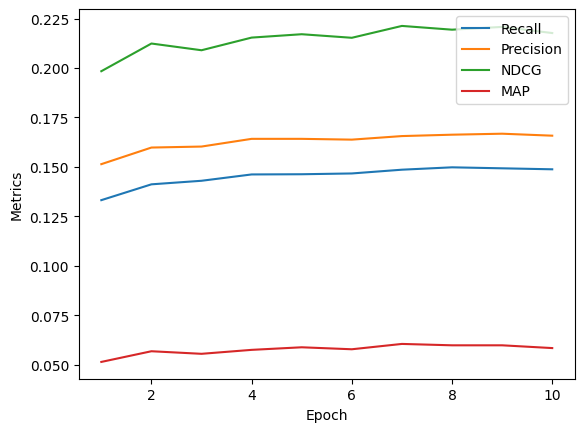

In [ ]:
#Plotting the evaluation metrics (recall, precision, NDCG, MAP) against the epoch numbers
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.plot(epoch_list, light_ndcg, label='NDCG')
plt.plot(epoch_list, light_map, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [ ]:
#Calculating the maximum values of precision, recall, NDCG, and MAP from the corresponding lists
max(light_precision), max(light_recall), max(light_ndcg), max(light_map)

(0.1668, 0.1498, 0.2213, 0.0605)

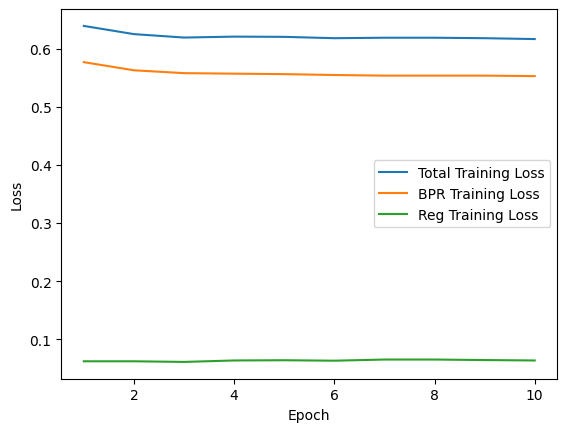

In [ ]:
#Plotting the training loss, BPR training loss, and regularization training loss over epochs
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
#Printing the metrics obtained after the last epoch of training for the test data and the loss value for the train data.
print("Last Epoch's Test Data Recall -> ", light_recall[-1])
print("Last Epoch's Test Data Precision -> ", light_precision[-1])
print("Last Epoch's Test Data NDCG -> ", light_ndcg[-1])
print("Last Epoch's Test Data MAP -> ", light_map[-1])
print("Last Epoch's Train Data Loss -> ", light_loss[-1])

Last Epoch's Test Data Recall ->  0.1488
Last Epoch's Test Data Precision ->  0.1658
Last Epoch's Test Data NDCG ->  0.2177
Last Epoch's Test Data MAP ->  0.0584
Last Epoch's Train Data Loss ->  0.6164


Recommending Movies to Specific Users Based on Their Ratings

Defines function "get_user_positive_items" that takes edge_index as input. Iterating through the columns of edge_index and creating a dictionary user_pos_items where the keys are user IDs and the values are lists of positive item IDs associated with each user. 

In [ ]:
def get_user_positive_items(edge_index):
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    print(user_pos_items)  #Printing the dictionary for debugging
    return user_pos_items

In [ ]:
#Creating a mapping dictionary where unique index values from the file are mapped to consecutive integer indices. 
def load_node_csv(path, index_col):
    df = pd.read_csv(path, index_col=index_col)
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    #Add a default index value for movies not found in the mapping
    max_index = max(mapping.values())
    for index in df.index.unique():
        if index not in mapping:
            max_index += 1
            mapping[index] = max_index
    return mapping

user_mapping = load_node_csv("/content/users.csv", index_col='UserID')
movie_mapping = load_node_csv("/content/movies.csv", index_col='MovieID')

The function "load_edge_csv" reads the data file containing edges between users and movies and creates an edge index tensor. It uses the provided mappings for the source and destination indices to convert the corresponding index values from the data file file to consecutive integer indices. It also applies a rating threshold to create edge attributes indicating whether the rating meets the threshold.

In [ ]:
#load edges between users and movies
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping, link_index_col, rating_threshold=4):
    df = pd.read_csv(path)
    edge_index = None
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold


    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])

    return torch.tensor(edge_index)


edge_index = load_edge_csv(
    "/content/ratings.csv",
    src_index_col='UserID',
    src_mapping=user_mapping,
    dst_index_col='MovieID',
    dst_mapping=movie_mapping,
    link_index_col='Rating',
    rating_threshold=4,
)

Using the model "lightgcn" for evaluation along with creating dictionaries to map movie IDs to their titles and genres. Also calling a function "user_pos_items" to obtain a dictionary of positive movie items for each user based on the provided edge information.

In [ ]:
lightgcn.eval()
mdf = pd.read_csv("/content/movies.csv")
movieid_title = pd.Series(mdf.Title.values, index=mdf.MovieID).to_dict()
movieid_genres = pd.Series(mdf.Genres.values, index=mdf.MovieID).to_dict()

user_pos_items = get_user_positive_items(edge_index)

#Printing a subset of the user-positive item mappings for debugging
print("User positive items:")
for user, items in user_pos_items.items():
    print(f"User {user}: {items[:5]}") 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



User 1263: [2918, 1229, 570, 1230, 3724]
User 1264: [3725, 1237, 2928, 1238, 2931]
User 1265: [1228, 1231, 1985, 1989, 2927]
User 1266: [585, 5, 1243, 1998, 586]
User 1267: [3862, 1231, 1232, 1233, 1236]
User 1268: [2918, 2928, 901, 775, 2789]
User 1269: [3882, 3390, 3753, 3793, 3827]
User 1270: [1990, 584, 0, 3878, 1995]
User 1271: [2918, 2920, 1232, 711, 584]
User 1272: [2918, 1230, 1232, 1234, 1236]
User 1273: [1229, 3862, 1230, 1231, 3724]
User 1274: [1230, 1242, 1250, 740, 1274]
User 1275: [2928, 1239, 0, 1995, 1245]
User 1276: [2926, 1384, 3012, 250, 3430]
User 1277: [1243, 1271, 2334, 2358, 2218]
User 1278: [1990, 2928, 2931, 1242, 1275]
User 1279: [3729, 2928, 585, 0, 3012]
User 1280: [2937, 3879, 589, 591, 896]
User 1281: [1239, 1995, 1250, 2222, 3355]
User 1282: [1990, 584, 0, 591, 593]
User 1283: [3724, 1232, 1989, 2928, 1239]
User 1284: [2918, 2919, 2920, 570, 3860]
User 1285: [2918, 2928, 586, 1263, 2961]
User 1286: [3724, 2928, 0, 2939, 3878]
User 1287: [2928, 1239, 1384,

Defines a function "make_predictions" that takes a user ID and the number of recommendations as input. First checking if the user ID exists and if it's within the valid range. Then, using the trained "lightgcn" model to make predictions by computing scores for all movies. Finally, retreiving movies rated highly by the user and printing their titles and genres.

In [ ]:
def make_predictions(user_ids, num_recs):
    for user_id in user_ids:
        #Check if user_id exists in user_mapping
        if user_id not in user_mapping:
            print(f"User ID {user_id} does not exist.")
            continue
        
        user = user_mapping[user_id]

        #Check if user index is within the range of model's embedding
        if user >= lightgcn.embedding.weight.shape[0]:
            print(f"User ID {user_id} is out of range.")
            continue
        
        emb0, out = lightgcn(edge_index)
        scores = torch.matmul(out[user], lightgcn.embedding.weight.T)

        _, indices = torch.topk(scores, k=len(movie_mapping))

        #Get movies rated highly by the user
        rated_highly_movies = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
        rated_highly_movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in rated_highly_movies]
        rated_highly_titles = [movieid_title[id] for id in rated_highly_movie_ids]
        rated_highly_genres = [movieid_genres[id] for id in rated_highly_movie_ids]

        print(f"Here are some movies that user {user_id} rated highly:")
        for i in range(len(rated_highly_titles)):
            print(f"title: {rated_highly_titles[i]}, genre: {rated_highly_genres[i]}")

        #Get movie IDs and titles for the recommended movies
        movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(idx)] for idx in indices if idx in movie_mapping.values()]
        titles = [movieid_title[id] for id in movie_ids]
        genres = [movieid_genres[id] for id in movie_ids]

        if len(titles) < num_recs:
            print(f"Not enough recommended movies available for user {user_id}.")
            continue

        print(f"\nHere are some recommended movies for user {user_id}:")
        for i in range(num_recs):
            print(f"title: {titles[i]}, genre: {genres[i]}")

In [ ]:
user_ids = [196, 256]  #List of user IDs
num_recs = 5  #Number of recommendations to make

make_predictions(user_ids, num_recs)

Here are some movies that user 196 rated highly:
title: Four Weddings and a Funeral (1994), genre: Comedy|Romance
title: Manchurian Candidate, The (1962), genre: Film-Noir|Thriller
title: Godfather: Part II, The (1974), genre: Action|Crime|Drama
title: Taxi Driver (1976), genre: Drama|Thriller
title: Reservoir Dogs (1992), genre: Crime|Thriller

Here are some recommended movies for user 196:
title: House II: The Second Story (1987), genre: Comedy|Horror
title: Arsenic and Old Lace (1944), genre: Comedy|Mystery|Thriller
title: Stand by Me (1986), genre: Adventure|Comedy|Drama
title: This Is Spinal Tap (1984), genre: Comedy|Drama|Musical
title: Eyes Without a Face (1959), genre: Horror
Here are some movies that user 256 rated highly:
title: Braveheart (1995), genre: Action|Drama|War
title: River Wild, The (1994), genre: Action|Thriller
title: Dead Presidents (1995), genre: Action|Crime|Drama
title: Star Trek: The Motion Picture (1979), genre: Action|Adventure|Sci-Fi
title: Mariachi, El (